In [1]:
import os
os.chdir('../')

import numpy as np
import tensorflow as tf
from scipy.misc import imread, imresize

from hart.data import disp
from hart.data.kitti.tools import get_data
from hart.model import util
from hart.model.attention_ops import FixedStdAttention
from hart.model.eval_tools import log_norm, log_ratios, log_values, make_expr_logger
from hart.model.tracker import HierarchicalAttentiveRecurrentTracker as HART
from hart.model.nn import AlexNetModel, IsTrainingLayer
from hart.train_tools import TrainSchedule, minimize_clipped

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
def load_imgs(img_dir):
    img_paths = sorted(os.listdir(img_dir))
    imgs = np.empty([len(img_paths), 1] + list(img_size), dtype=np.float32)
    for i, img_path in enumerate(img_paths):
        img_path= os.path.join(img_dir, img_path)
        imgs[i, 0] = imresize(imread(img_path), img_size[:2])
        
    return imgs

In [3]:
alexnet_dir = 'checkpoints'
img_dir = 'imgs'
# checkpoint_path = 'checkpoints/kitti/pretrained/2017_07_06_16.41/model.ckpt-142320'
checkpoint_path = 'checkpoints/kitti/pretrained/model.ckpt-347346'

batch_size = 1
img_size = 187, 621, 3
crop_size = 56, 56, 3

rnn_units = 100
norm = 'batch'
keep_prob = .75

img_size, crop_size = [np.asarray(i) for i in (img_size, crop_size)]
keys = ['img', 'bbox', 'presence']

bbox_shape = (1, 1, 4)

In [4]:
tf.reset_default_graph()
util.set_random_seed(0)

x = tf.placeholder(tf.float32, [None, batch_size] + list(img_size), name='image')
y0 = tf.placeholder(tf.float32, bbox_shape, name='bbox')
p0 = tf.ones(y0.get_shape()[:-1], dtype=tf.uint8, name='presence')

is_training = IsTrainingLayer()
builder = AlexNetModel(alexnet_dir, layer='conv3', n_out_feature_maps=5, upsample=False, normlayer=norm,
                       keep_prob=keep_prob, is_training=is_training)

model = HART(x, y0, p0, batch_size, crop_size, builder, rnn_units,
             bbox_gain=[-4.78, -1.8, -3., -1.8],
             zoneout_prob=(.05, .05),
             normalize_glimpse=True,
             attention_module=FixedStdAttention,
             debug=True,
             transform_init_features=True,
             transform_init_state=True,
             dfn_readout=True,
             feature_shape=(14, 14),
             is_training=is_training)

In [5]:
saver = tf.train.Saver()
sess = tf.Session()

In [6]:
sess.run(tf.global_variables_initializer())
saver.restore(sess, checkpoint_path)
model.test_mode(sess)

INFO:tensorflow:Restoring parameters from checkpoints/kitti/pretrained/model.ckpt-347346


In [7]:
imgs = load_imgs(img_dir)
##bbox = y_origin,x_origin,y_add,x_add
#bbox = [88, 250, 18, 25]
x_start = 58
y_start = 90
x_end = 101
y_end = 106
bbox = [y_start,x_start,y_end-y_start,x_end-x_start]

/home/iysaleh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/iysaleh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [8]:
feed_dict = {x: imgs, y0: np.reshape(bbox, bbox_shape)}
tensors = [model.pred_bbox, model.att_pred_bbox, model.glimpse, model.obj_mask]
pred_bbox, pred_att, glimpse, obj_mask = sess.run(tensors, feed_dict)

(187, 0)

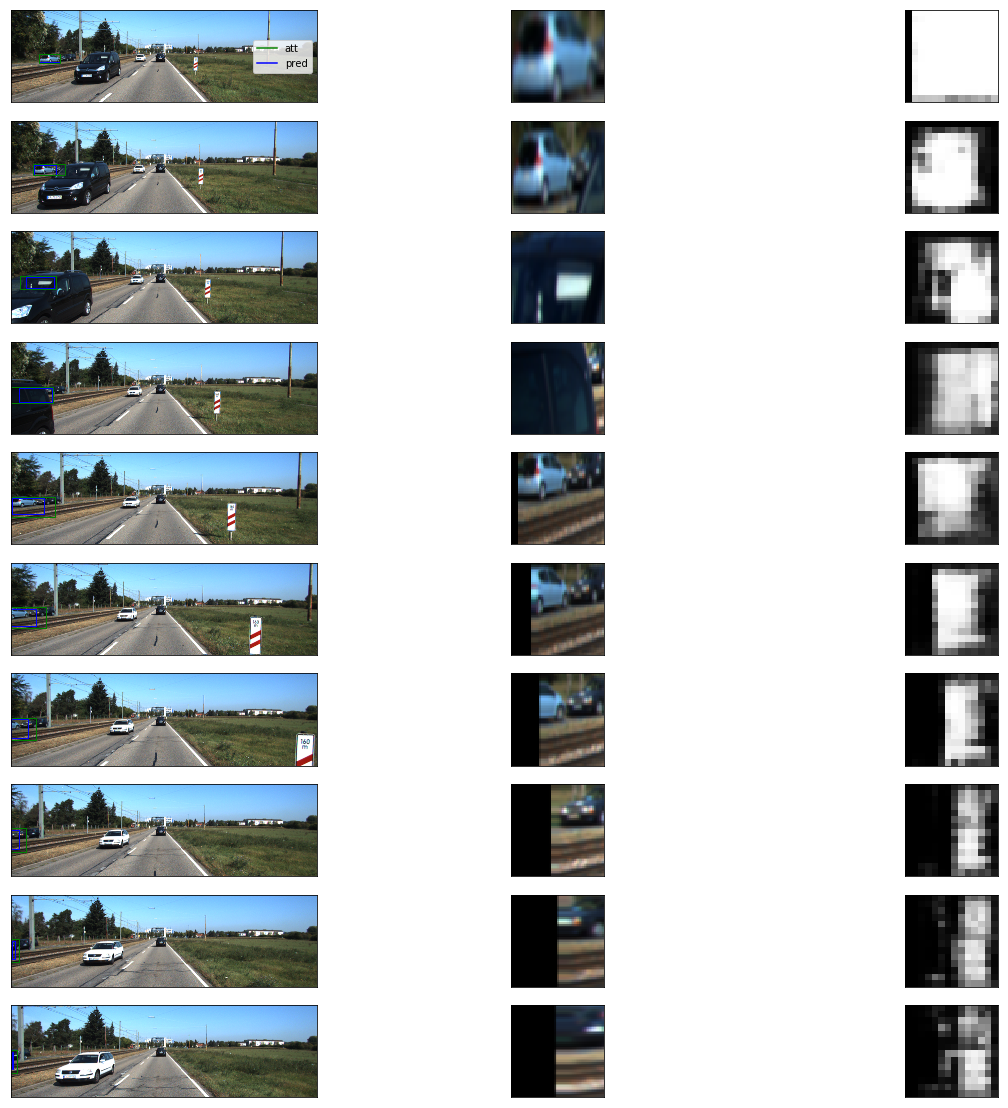

In [9]:
n = imgs.shape[0]
fig, axes = plt.subplots(n, 3, figsize=(20, 2*n))
for i, ax in enumerate(axes):
    ax[0].imshow(imgs[i].squeeze() / 255.)
    ax[1].imshow(glimpse[i].squeeze())
    ax[2].imshow(obj_mask[i].squeeze(), cmap='gray', vmin=0., vmax=1.)
    disp.rect(pred_bbox[i].squeeze(), 'b', ax=ax[0])
    disp.rect(pred_att[i].squeeze(), 'g', ax=ax[0])
    for a in ax:
        a.xaxis.set_visible(False)
        a.yaxis.set_visible(False)
        
axes[0, 0].plot([], c='g', label='att')
axes[0, 0].plot([], c='b', label='pred')
axes[0, 0].legend(loc='center right')
axes[0, 0].set_xlim([0, img_size[1]])
axes[0, 0].set_ylim([img_size[0], 0])